In [1]:
import numpy as np
import pandas as pd
import h5py
import os

from keras.preprocessing import image

Using TensorFlow backend.


In [12]:
def prepare_pascal3d(data_path, out_path,
                     load_synthetic=False,
                     extract_cnn_features=False,
                     synth_path=None):
    """Converts cropped images and orientation annotation from Pascal3D+ into h5 database.
    
    Pascal3D+ should be preprocessed first via 
        https://github.com/ShapeNet/RenderForCNN/blob/master/view_estimation/prepare_testing_data.py
        https://github.com/ShapeNet/RenderForCNN/blob/master/view_estimation/prepare_training_data.py
    
    Synthetic images could be downloaded from here:
        https://shapenet.cs.stanford.edu/media/syn_images_cropped_bkg_overlaid.tar
    
    # Arguments
    
        data_path: path to preprocessed data (/pathto/RenderForCNN/data/real_images/)
        
        out_path: savepath for created h5 database
        
        extract_resnet_features: whether to extract features with pretrained ResNet50
        
        load_synthetic: whether to load synthtetic rendered images
        
        synth_path: path to synthetic images
        
    """
    
    classes = {0: 'aeroplane',
               1: 'bicycle',
               2: 'boat',
               3: 'bottle',
               4: 'bus',
               5: 'car',
               6: 'chair',
               7: 'diningtable',
               8: 'motorbike',
               9: 'sofa',
               10: 'train',
               11: 'tvmonitor'}
    
    def _load_data_by_labels(lpath, class_name, data_part):
        
        print("loading labels from path : %s" % lpath)
        labels = pd.read_csv(lpath, delimiter=' ', header=None, 
                             names=['image_path', 'class_id', 'azimuth', 'elevation', 'tilt'])

        labels_np = np.asarray(labels[['class_id', 'azimuth', 'elevation', 'tilt']])
        
        images = np.zeros([labels.shape[0], 224, 224, 3], dtype='uint8')

        for i, img in enumerate(list(labels.image_path)):
            img = image.load_img(img, target_size=(224, 224))
            x = np.asarray(img)
            images[i] = x
                
        pascal_db.create_dataset(os.path.join(data_part, class_name, 'labels'), data=labels_np)
        pascal_db.create_dataset(os.path.join(data_part, class_name, 'images'), data=images)
        
        return 
    
    def _load_data_part(paths, part_name):
        
        for cid, lpath in enumerate(paths):
            _load_data_by_labels(lpath, classes[cid], part_name)
        
        return
    
    pascal_db = h5py.File(out_path, 'w')
    
    print("Loading real train images..")
    train_real_labels_global_path = os.path.join(data_path, 'real_images', 'voc12train_all_gt_bbox')
    train_real_labels_paths = [os.path.join(train_real_labels_global_path, (classes[key]+'.txt')) for key in classes.keys()]
    _load_data_part(train_real_labels_paths, 'train_real')
    
    print("Loading synthetic train images..")
    train_syn_labels_global_path = os.path.join(data_path, 'syn_lmdbs')
    train_syn_labels_paths = [os.path.join(train_syn_labels_global_path, (classes[key]+'_train.txt')) for key in classes.keys()]
    _load_data_part(train_syn_labels_paths, 'train_synthetic')
    
    print("Loading real test images (Pascal3d validation gt bboxes)..")
    test_real_gt_labels_global_path = os.path.join(data_path, 'real_images', 'voc12val_easy_gt_bbox')
    test_real_gt_labels_paths = [os.path.join(test_real_gt_labels_global_path, (classes[key]+'.txt')) for key in classes.keys()]
    _load_data_part(test_real_gt_labels_paths, 'test_real_gt_boxes')
    
    print("Loading real test images (Pascal3d validation FRCNN detections)..")
    test_real_det_labels_global_path = os.path.join(data_path, 'real_images', 'voc12val_det_bbox')
    test_real_det_labels_paths = [os.path.join(test_real_det_labels_global_path, (classes[key]+'.txt')) for key in classes.keys()]
    _load_data_part(test_real_det_labels_paths, 'test_real_frcnn_boxes')
    
    print("Loading synthetic test images..")
    test_syn_labels_global_path = os.path.join(data_path, 'syn_lmdbs')
    test_syn_labels_paths = [os.path.join(test_syn_labels_global_path, (classes[key]+'_test.txt')) for key in classes.keys()]
    _load_data_part(test_syn_labels_paths, 'test_syn_boxes')
    
    pascal_db.close()
    
    return

In [13]:
data_path = '/home/sprokudin/RenderForCNN/data/'
db_path = '../data/pascal3d_real_synthetic.h5'

In [ ]:
#os.remove(db_path)
prepare_pascal3d(data_path, db_path, extract_cnn_features=False)

Loading real train images..
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/aeroplane.txt
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/bicycle.txt
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/boat.txt
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/bottle.txt
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/bus.txt
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/car.txt
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/chair.txt
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/diningtable.txt
loading labels from path : /home/sprokudin/RenderForCNN/data/real_images/voc12train_all_gt_bbox/motorbike.txt
loadin

In [13]:
pascal_db = h5py.File(db_path, 'r')

train_images = pascal_db['train/aeroplane/images']

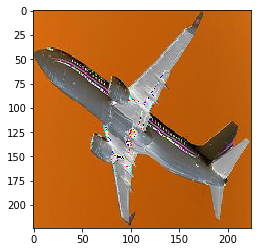

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_images[0])

In [52]:
pascal_db.close()

In [43]:
pascal_db['train/aeroplane/resnet_features']

KeyError: "Unable to open object (Object 'resnet_features' doesn't exist)"